### In this nb I will use the improvements made in Exploratory3 (coded into utils package) to analyse more scenarios. I also come up with a novel way to analyse how shock response changes over time.

In [1]:
from utils import *
env()

--------- Dependencies ---------
python: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]
numpy: 1.21.0
pandas: 1.2.4
matplotlib: 3.4.2
statsmodels: 0.13.0


## General Models

### EPU

In [2]:
wti = load('data/WTI.csv').pct_change().dropna()
spot = clean_series('spot', wti)
c1 = clean_series('contract_1', wti)
c3 = clean_series('contract_3', wti)

In [3]:
epu = load('data/EPUGlobal.csv')
epu_shock = calc_shock('GEPU_current', epu)

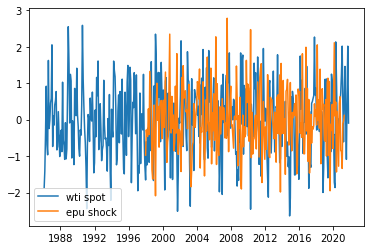

In [4]:
plt.plot(spot, label='wti spot')
plt.plot(epu_shock, label='epu shock')
plt.legend()

In [5]:
model1 = dl('spot', 'GEPU_current', spot.join(epu_shock))
model2 = dl('contract_1', 'GEPU_current', c1.join(epu_shock))
model3 = dl('contract_3', 'GEPU_current', c3.join(epu_shock))

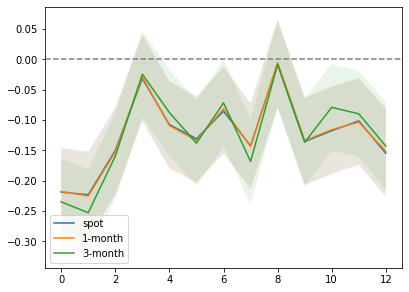

In [6]:
draw((model1, model2, model3),
    labels=('spot', '1-month', '3-month')
    )

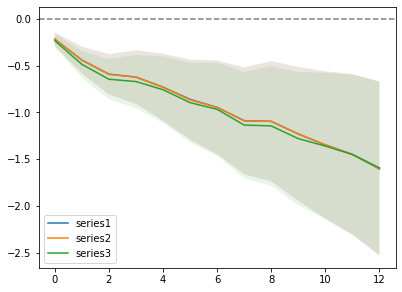

In [7]:
draw((model1, model2, model3), cumulative=True)

### GPR

In [8]:
gpr = load('data/GPRGlobal.csv')
gpr_shock = calc_shock('GPRI', gpr)

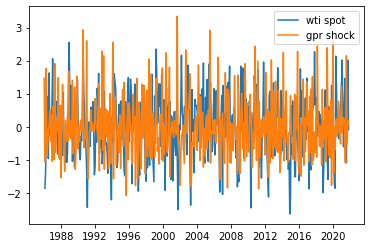

In [9]:
plt.plot(spot, label='wti spot')
plt.plot(gpr_shock, label='gpr shock')
plt.legend()

In [10]:
model4 = dl('spot', 'GPRI', spot.join(gpr_shock))
model5 = dl('contract_1', 'GPRI', c1.join(gpr_shock))
model6 = dl('contract_3', 'GPRI', c3.join(gpr_shock))

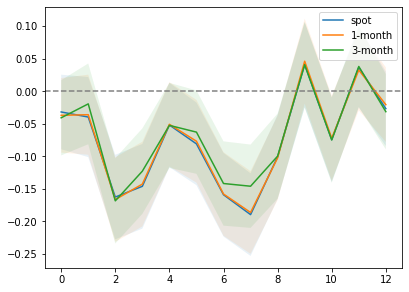

In [11]:
draw((model4, model5, model6),
     labels=('spot', '1-month', '3-month')
    )

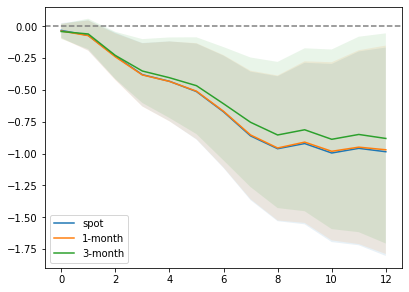

In [12]:
draw((model4, model5, model6),
     labels=('spot', '1-month', '3-month'),
     cumulative=True)

## Time Slicing

### GPR Pre & Post Iraq

In [13]:
model7 = dl('spot', 'GPRI', spot.join(gpr_shock)[:'2003-01-01'])
model8 = dl('spot', 'GPRI', spot.join(gpr_shock)['2003-01-01':])

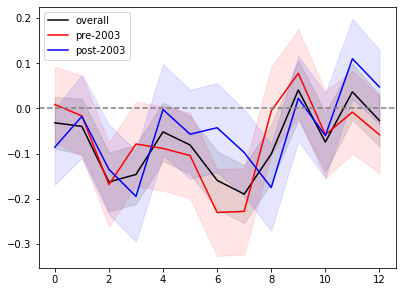

In [14]:
draw((model4, model7, model8), 
     labels=('overall', 'pre-2003', 'post-2003'),
     colors=('black', 'red', 'blue')
    )

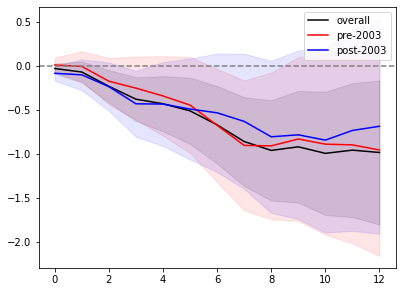

In [15]:
draw((model4, model7, model8), 
     labels=('overall', 'pre-2003', 'post-2003'),
     colors=('black', 'red', 'blue'),
     cumulative=True
    )

It seems that crude is more sensitive to GRP shocks post-2003. Let's see how it evolves over the decade between 2004 and 2015.

In [16]:
models1 = {}
for i in range(12):
    year = 2004 + i
    model = dl('spot', 'GPRI', spot.join(gpr_shock)[f'{year}-01-01':])
    models1[year] = model

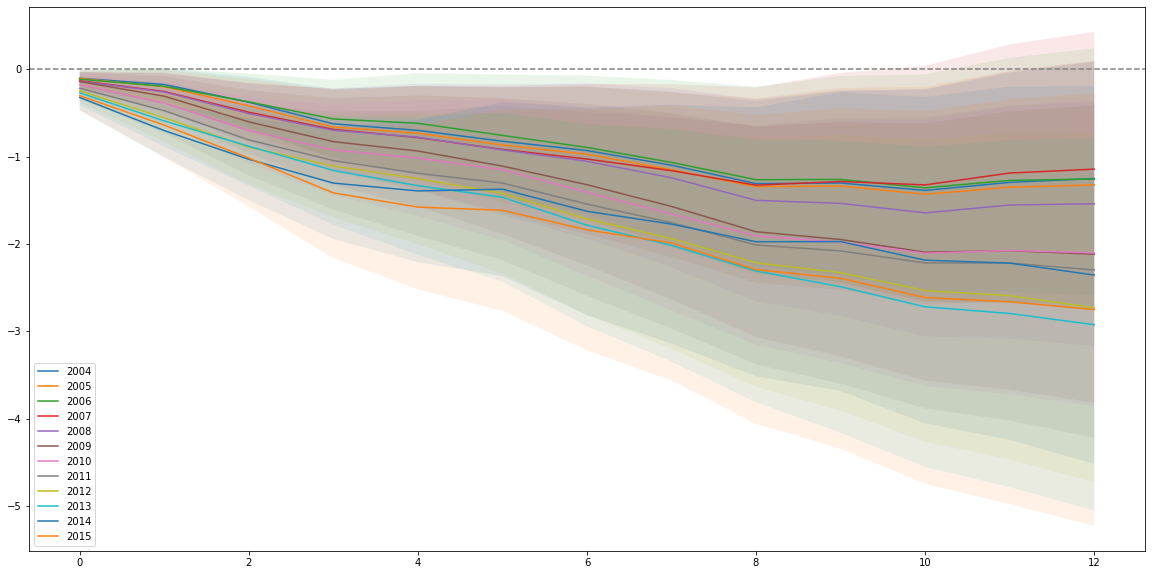

In [17]:
draw(list(models1.values()), 
     labels=(list(models1.keys())),
     cumulative=True,
     figsize=(20,10)
    )

Interesting - crude prices got more sensitive to GPR shocks as time went on. I wonder if the pattern persisted before 2003.

In [18]:
models2 = {}
for i in range(4):
    year = 2000 + i
    model = dl('spot', 'GPRI', spot.join(gpr_shock)[f'{year}-01-01':])
    models2[year] = model

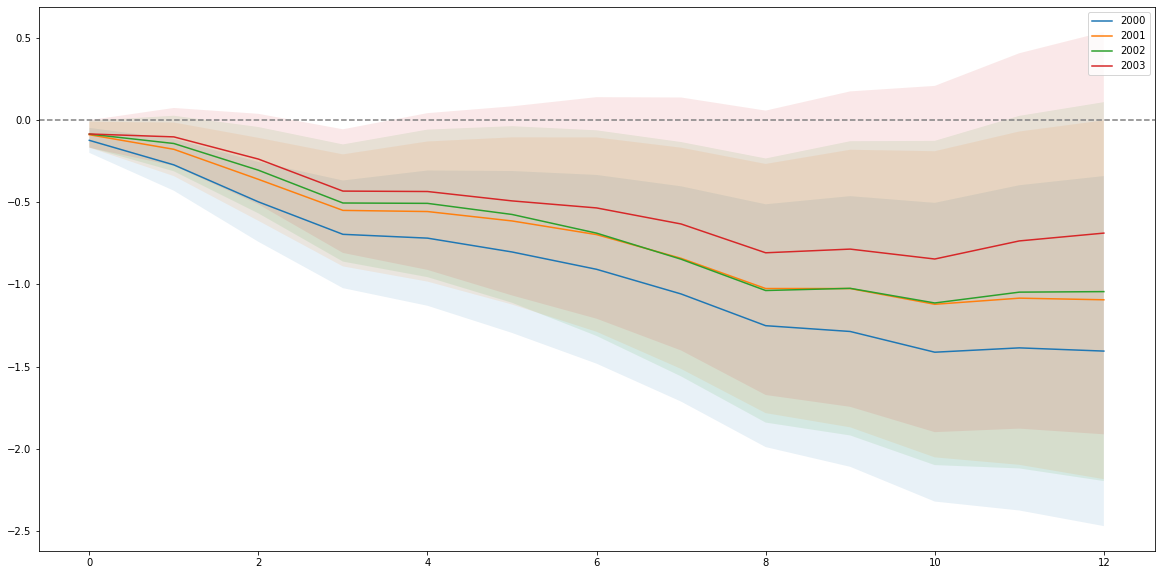

In [19]:
draw(list(models2.values()), 
     labels=(list(models2.keys())),
     cumulative=True,
     figsize=(20,10)
    )

Now let's see how it varied through time.

In [20]:
models3 = {**models1, **models2}

In [21]:
betas = {i: [] for i in range(13)}

In [22]:
for i in range(16):
    year = 2000 + i
    params = np.cumsum(models3[year].params[1:])
    for i in range(13):
        betas[i].append(params[i])

<AxesSubplot:>

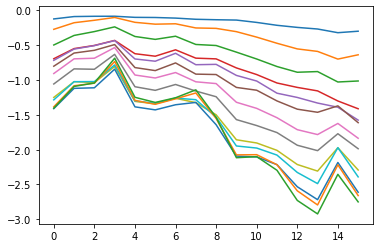

In [23]:
betas_df = pd.DataFrame(betas)
betas_df.plot(legend=False)

It seems like the inclusion of 2003 heavily skews estimates upwards, probably because oil prices spiked after the Iraq invasion. Otherwise, there has indeed been a steady downtrend in crude returns when GPR shocks occur, though looks to be stabalizing from 2013 to 2015.

For robustness let's run this the other way with dates from 2015 to 1995.

In [24]:
models4 = {}
for i in range(16):
    year = 2000 + i
    model = dl('spot', 'GPRI', spot.join(gpr_shock)[:f'{year}-12-31'])
    models4[year] = model

<AxesSubplot:>

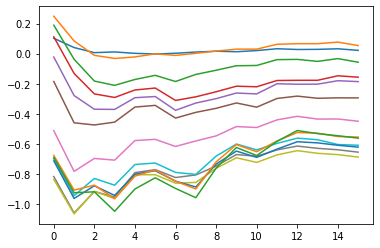

In [25]:
betas2 = {i: [] for i in range(13)}
for i in range(16):
    year = 2000 + i
    params = np.cumsum(models4[year].params[1:])
    for i in range(13):
        betas2[i].append(params[i])
betas_df2 = pd.DataFrame(betas2)
betas_df2.plot(legend=False)

It looks like pre-2000, GPR caused positive shocks in crude returns. This is not surprising since the Middle East was the top supplier and US interventionalism began in the 80s. 

Overall, our result is strangely consistent with Kilian and Hamilton's conflicting approaches to oil price drivers in the early 21st century, because dynamics have gradually changed.

To isolate the effects each year, it may be worth finding the net effect of the two series.

<AxesSubplot:>

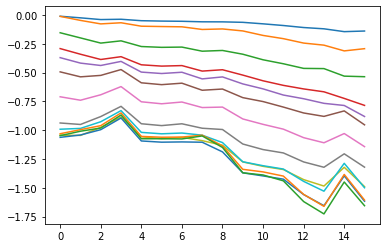

In [26]:
net_beta = {i: [] for i in range(13)}
for i in range(13):
    net_beta[i] = (np.array(betas[i]) + np.array(betas2[i]))/2
net_df = pd.DataFrame(net_beta)
net_df.plot(legend=False)

After making the series more robust we see that the Iraq invasion did increased responsiveness to GPR shocks in 2004. We also see a clear trend of increased responsiveness from 1995 to 2015.

<img src="https://www.mdpi.com/energies/energies-13-04277/article_deploy/html/images/energies-13-04277-g001.png" width="500">

We can double check this direction is correct on the overlay above - remember we are looking at the effect of shocks on near-term (monthly) returns.

### EPU Pre & Post GFC

In [27]:
model9 = dl('spot', 'GEPU_current', spot.join(epu_shock)[:'2007-01-01'])
model10 = dl('spot', 'GEPU_current', spot.join(epu_shock)['2007-01-01':])

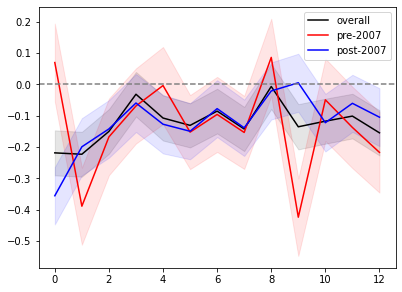

In [28]:
draw((model1, model9, model10), 
     labels=('overall', 'pre-2007', 'post-2007'),
     colors=('black', 'red', 'blue')
    )

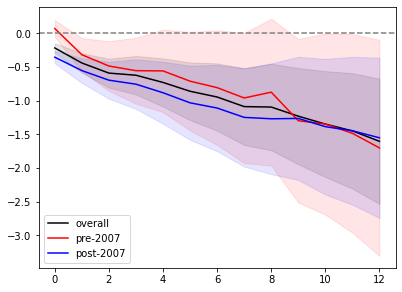

In [29]:
draw((model1, model9, model10), 
     labels=('overall', 'pre-2007', 'post-2007'),
     colors=('black', 'red', 'blue'),
     cumulative=True
    )

Let's see how things evolved for EPU from 2000 to 2015 (because EPU doesn't stretch back as far).

In [30]:
models5 = {}
for i in range(16):
    year = 2000 + i
    model = dl('spot', 'GEPU_current', spot.join(epu_shock)[f'{year}-01-01':])
    models5[year] = model

<AxesSubplot:>

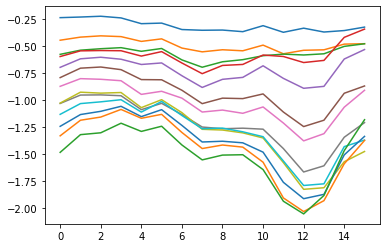

In [31]:
betas3 = {i: [] for i in range(13)}
for i in range(16):
    year = 2000 + i
    params = np.cumsum(models5[year].params[1:])
    for i in range(13):
        betas3[i].append(params[i])
betas_df3 = pd.DataFrame(betas3)
betas_df3.plot(legend=False)

In [32]:
models6 = {}
for i in range(16):
    year = 2000 + i
    model = dl('spot', 'GEPU_current', spot.join(epu_shock)[:f'{year}-12-31'])
    models6[year] = model

<AxesSubplot:>

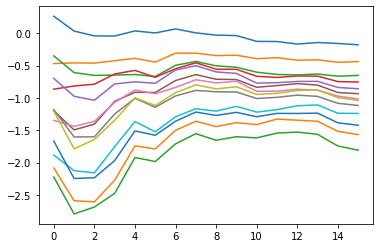

In [33]:
betas4 = {i: [] for i in range(13)}
for i in range(16):
    year = 2000 + i
    params = np.cumsum(models6[year].params[1:])
    for i in range(13):
        betas4[i].append(params[i])
betas_df4 = pd.DataFrame(betas4)
betas_df4.plot(legend=False)

<AxesSubplot:>

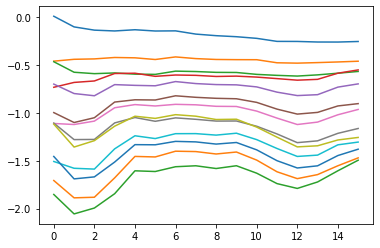

In [34]:
net_beta = {i: [] for i in range(13)}
for i in range(13):
    net_beta[i] = (np.array(betas3[i]) + np.array(betas4[i]))/2
net_df = pd.DataFrame(net_beta)
net_df.plot(legend=False)

Generally there is a constriction in the coefficients, suggesting that the immediate impact of EPU shocks are greater but last shorter. It is interesting how there's an almost opposite relationship with the GPR and with the EPU.

<img src="https://www.researchgate.net/profile/Tinghui-Li-3/publication/343609886/figure/fig1/AS:923706092175361@1597240102499/Trend-of-Brent-oil-spot-price-and-global-economic-policy-uncertainty-GEPU-Notes-GEPU.png" width="500">

We can intuitively check the results on the overlay above.